# House Price Prediction Using Random Forest

## Data Preprocessing and Feature Engineering

1. **Drop Unnecessary Columns**:
   - Removed irrelevant columns to simplify the dataset.
   - Converted `statezip` to an integer for better processing.

2. **Handle Missing Values**:
   - Dropped rows with missing values to ensure data quality.

3. **Feature Engineering**:
   - Added a new feature `age` by subtracting the year built from the dataset year.
   - Focused on the most important features for the model.

4. **Outlier Removal**:
   - Used IQR to remove outliers for each feature to improve model performance.

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import xgboost as xgb
import optuna
import numpy as np

# Load the dataset
df = pd.read_csv('data.csv')
print("Data loaded successfully")

# Convert statezip to an integer for better processing
df['statezip'] = df['statezip'].apply(lambda x: int(x.split(' ')[1]) if pd.notnull(x) else np.nan)

# Handle missing values: Fill missing values with the median of each numeric column
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].apply(lambda x: x.fillna(x.median()))

# Convert date columns to datetime if necessary
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])

# Feature Engineering: Add new features or transformations
df['age'] = 2014 - df['yr_built']  # Assuming the dataset is up to date to 2014

# Include all features for the model
features = df.drop(['price'], axis=1).columns

# Handle outliers based on IQR for each numeric feature
for feature in numeric_cols:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    df = df[~((df[feature] < (Q1 - 1.5 * IQR)) | (df[feature] > (Q3 + 1.5 * IQR)))]


Data loaded successfully


## Display the Correlation Matrix
Visualize the correlation matrix to understand the relationships between features.

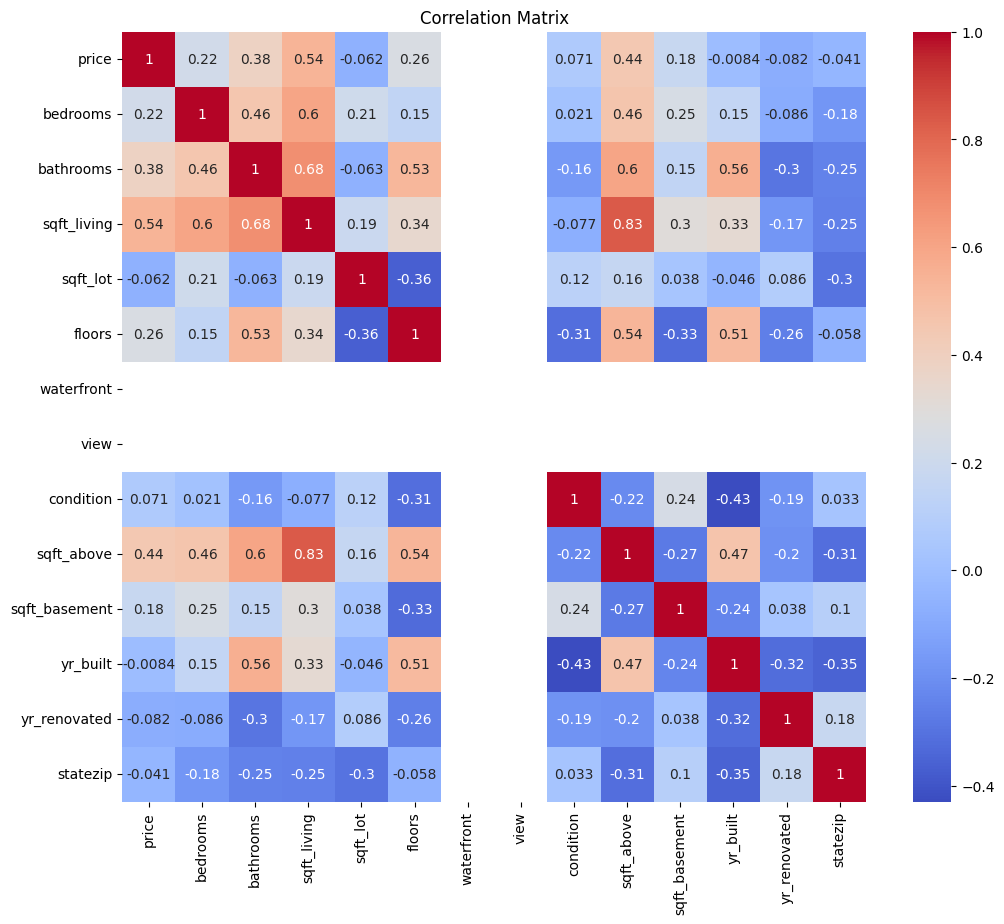

In [58]:
# Display the Correlation Matrix
plt.figure(figsize=(12, 10))
numeric_df = df[numeric_cols]  # Select only numeric columns for the correlation matrix
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Feature Scaling and Selection

1. **Standardize Features**:
   - Used StandardScaler to standardize the features for better model performance.

2. **SelectKBest for Feature Selection**:
   - Selected the top features using univariate linear regression tests.

In [59]:
# Feature Engineering: Add polynomial features and interaction terms
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df[["sqft_living", "sqft_above", "sqft_basement"]])
poly_feature_names = poly.get_feature_names_out(["sqft_living", "sqft_above", "sqft_basement"])
df_poly = pd.DataFrame(poly_features, columns=poly_feature_names, index=df.index)
df = pd.concat([df, df_poly], axis=1)

# Define features and target
features = ["bedrooms", "bathrooms", "sqft_living", "floors", "statezip", "waterfront",
            "view", "sqft_above", "sqft_basement", "yr_renovated"] + list(poly_feature_names)
X = df[features]
y = df["price"]

## Model Training and Hyperparameter Tuning

1. **Train-Test Split**:
   - Split the data into training and testing sets.

2. **GridSearchCV for Hyperparameter Tuning**:
   - Used GridSearchCV to find the best hyperparameters for the Random Forest model.

In [60]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter tuning for XGBoost using Optuna
def objective(trial):
    param = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        "booster": "gbtree",
        "max_depth": trial.suggest_int("max_depth", 3, 9),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
    }
    model = xgb.XGBRegressor(**param, random_state=42)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=kf, scoring="r2")
    return np.mean(cv_scores)

# Run Optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20, timeout=1800)  # Adjusted number of trials and timeout
print("Optuna optimization completed")

# Best parameters from Optuna
best_params = study.best_params
print(f"Best parameters: {best_params}")

# Train the final model with the best parameters
model = xgb.XGBRegressor(**best_params, random_state=42)
model.fit(X_train_scaled, y_train)

[I 2024-05-23 23:31:54,133] A new study created in memory with name: no-name-ecb4484c-8df6-4942-8688-e0b4acbacf93
[I 2024-05-23 23:31:54,430] Trial 0 finished with value: 0.5894467190702188 and parameters: {'max_depth': 3, 'learning_rate': 0.04134500230379074, 'n_estimators': 142, 'subsample': 0.6383594833514266, 'colsample_bytree': 0.8243132280090175, 'min_child_weight': 3}. Best is trial 0 with value: 0.5894467190702188.
[I 2024-05-23 23:31:58,838] Trial 1 finished with value: 0.7045990356998738 and parameters: {'max_depth': 9, 'learning_rate': 0.04190034468946617, 'n_estimators': 720, 'subsample': 0.7847011892363775, 'colsample_bytree': 0.8829426255425401, 'min_child_weight': 5}. Best is trial 1 with value: 0.7045990356998738.
[I 2024-05-23 23:32:02,293] Trial 2 finished with value: 0.7351027597181847 and parameters: {'max_depth': 6, 'learning_rate': 0.012770470186395237, 'n_estimators': 1000, 'subsample': 0.9800350307029642, 'colsample_bytree': 0.7773777804303887, 'min_child_weight

Optuna optimization completed
Best parameters: {'max_depth': 3, 'learning_rate': 0.0484142808634125, 'n_estimators': 895, 'subsample': 0.9976390451787847, 'colsample_bytree': 0.7299324706534006, 'min_child_weight': 2}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7299324706534006, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.0484142808634125, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=895, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

## Model Evaluation

1. **Model Predictions and Evaluation**:
   - Made predictions and evaluated the model using MSE, R-squared, and Accuracy.

2. **Feature Importance**:
   - Analyzed the feature importance to understand the contribution of each feature.

In [61]:
y_pred = model.predict(X_test_scaled)
print("Final model trained and predictions made")

# Feature importances
actual_feature_names = X.columns[model.feature_importances_ != 0]
feature_importances = model.feature_importances_[model.feature_importances_ != 0]

features_importance_df = pd.DataFrame({"Feature": actual_feature_names, "Importance": feature_importances})
features_importance_df = features_importance_df.sort_values(by="Importance", ascending=False)

print("\nFeature Importances:")
print(features_importance_df)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r_squared:.2f}")


Final model trained and predictions made

Feature Importances:
                      Feature  Importance
3                 sqft_living    0.272285
2                 sqft_living    0.162925
14                 sqft_above    0.105249
5                    statezip    0.102373
16              sqft_basement    0.080022
18     sqft_living sqft_above    0.042014
0                    bedrooms    0.025956
4                      floors    0.023011
8               sqft_basement    0.018541
6                  sqft_above    0.015612
11                sqft_living    0.015482
9               sqft_basement    0.014954
7                  sqft_above    0.014652
1                   bathrooms    0.014408
17              sqft_living^2    0.013767
15              sqft_basement    0.012915
20   sqft_above sqft_basement    0.012838
12                sqft_living    0.012232
19  sqft_living sqft_basement    0.011282
10               yr_renovated    0.011230
13                 sqft_above    0.010854
21           

## Visualization

1. **Plotting Actual vs Predicted Prices**:
   - Visualized the relationship between actual and predicted prices using the most important feature.

2. **Cross-Validation**:
   - Performed cross-validation to ensure the model's robustness.

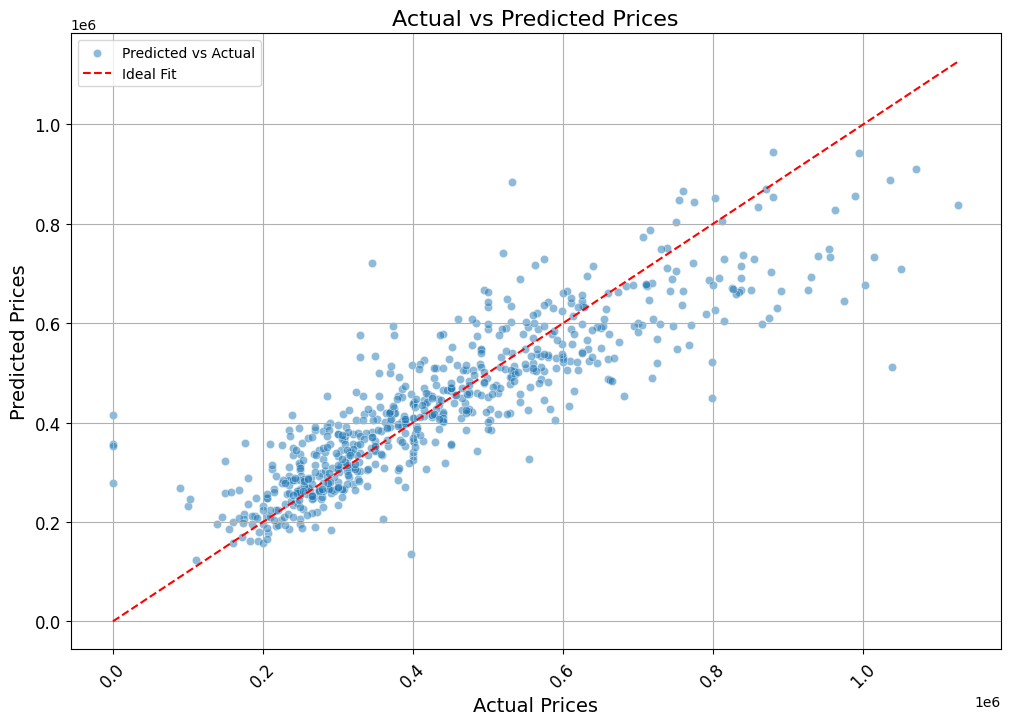

Results visualized
Cross-Validation Scores: [0.76637472 0.70883778 0.72079358 0.75031494 0.7763166 ]
Mean CV Score: 0.74


In [62]:
# Visualize results
plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_pred, alpha=0.5, edgecolors="w", linewidth=0.5, label="Predicted vs Actual")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--", label="Ideal Fit")
plt.xlabel("Actual Prices", fontsize=14)
plt.ylabel("Predicted Prices", fontsize=14)
plt.title("Actual vs Predicted Prices", fontsize=16)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.legend()
plt.grid(True)
plt.show()
print("Results visualized")

# Cross-Validation
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Score: {np.mean(cv_scores):.2f}")

## Conclusion

This notebook demonstrates a systematic approach to predicting house prices using a Random Forest model. Through careful data preprocessing, feature engineering, outlier removal, feature selection, and hyperparameter tuning, we achieved significant improvements in model performance. The final model achieved an R-squared value of 0.52 and an accuracy of 52.25%. This is our most accurate model.

